# Coursework 3: Generative Models

#### Instructions

Please submit on CATe a zip file named *CW3.zip* containing the following:
1. A version of this notebook containing your answers. Write your answers in the cells below each question.
2. Your trained models as *CAE_model.pth, DCGAN_model_D.pth, DCGAN_model_G.pth*
3. You training losses as *train_losses_CAE.npy*, *train_losses_D.npy*, *train_losses_G.npy*

#### Working environment:

Similarly to the previous coursework, we recommend that you use Google Colaboratory in order to train the required networks.

**The deadline for submission is 19:00, Thursday 28th February, 2019**

## Introduction

For this coursework you are asked to implement two commonly used generative models:
1. A **Convolutional Autoencoder (CAE)**
2. A **Deep Convolutional Generative Adversarial Network (DCGAN)**

The dataset you will be using is the CIFAR-10 (https://www.cs.toronto.edu/~kriz/cifar.html).

## Part 1 (50 points)

1. For the CAE, the success of your models will be tested as follows:
    - **By the autoencoders' reconstruction error**. You will need to achieve a low enough error in order to reconstruct the images of the dataset with relatively high fidelity. You will have to provide us with your best model's training loss curve, reconstruction error on the test set and some reconstructed images in the respective cells.
    - **By the representation learning capabilities of your model**. In particular, autoencoders are known to be able to learn quite informative features in their latent space (embeddings) that can later be used for downstream tasks. In this coursework you are asked to use the representations that your pre-trained encoder yields in order to do image classification. You can use your favourite classification module on top of the features in order to solve the problem *(Hint: a simple Support Vector Machine - SVM - is acceptable. Alternatively, you can devise more complex models such as a Multilayer Fully Connected Network)*.
 
## Part 2 (50 points)
2. For the DCGAN, The success of your models will be tested as follows:
    - **By the model's training error**. You will need to achieve relatively balanced errors for the generator and the discriminator of your model in order to sample realistic images from the generator. You will have to provide us with your best model's training losses curves, a discussion on how you concluded to the chosen architecture, and visualizations of generated samples in the respective cells. Your results do not have to be perfect, however a good discussion on the choice of architecture will be valued.
    - **By avoiding mode collapse**. A common problem of training GANs is that they end up generating only a few different samples (if not only one), rather than learning the whole distribution of the training data. This problem is referred to as mode collapse. You will need to make a discussion on whether you noticed mode collapse or not during your experimentation and if yes, how you addressed it.


In [0]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt


def denorm(x, channels=None, w=None ,h=None, resize = False):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    if resize:
        if channels is None or w is None or h is None:
            print('Number of channels, width and height must be provided for resize.')
        x = x.view(x.size(0), channels, w, h)
    return x

def show(img):
    if torch.cuda.is_available():
        img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))


### Device Selection

In [0]:
GPU = True
device_idx = 0
if GPU:
    device = torch.device("cuda:" + str(device_idx) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(device)

cuda:0


### Reproducibility

In [0]:
# We set a random seed to ensure that your results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

### Data loading

In [0]:
batch_size = 128

if not os.path.exists('./CW/CAE'):
    os.makedirs('./CW/CAE')
if not os.path.exists('./CW/DCGAN'):
    os.makedirs('./CW/DCGAN')


NUM_TRAIN = 49000

transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])


data_dir = './datasets'
cifar10_train = datasets.CIFAR10(data_dir, train=True, download=True,
                             transform=transform)
cifar10_val = datasets.CIFAR10(data_dir, train=True, download=True,
                           transform=transform)
cifar10_test = datasets.CIFAR10(data_dir, train=False, download=True, 
                            transform=transform)

loader_train = DataLoader(cifar10_train, batch_size=batch_size, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
loader_val = DataLoader(cifar10_val, batch_size=batch_size, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))
loader_test = DataLoader(cifar10_test, batch_size=batch_size)

it = iter(loader_test)
sample_inputs, _ = next(it)
fixed_input = sample_inputs[0:32, :, :, :]
save_image(denorm(fixed_input), './CW/CAE/input_sample.png')

Files already downloaded and verified
Files already downloaded and verified


## Part 1 - Convolutional Autoencoder

### Part 1.1 (30 points)
**Your Task**: 

a. Implement the CAE architecture. Fill in the missing parts in the cells below in order to complete the CAE class. You will need to define:

- The hyperparameters
- The constructor
- `encode`
- `decode`

b. Plot your training loss curve (x-axis: epochs, y-axis: loss)

c. Calculate the reconstruction error on your test set

d. Visualize a subset of the images of the test set and their reconstructions

For b., c. and d. the code is already given. Make sure that the version of the notebook you deliver includes these results. 

Some reccomendations:
- add several convolutional layers (3-4).
- accelerate training with batch normalization after every convolutional layer or fully connected layer.
- use the appropriate activation functions. 
- Encoder module: hierarchially downsample your images with pooling layers, or strided convolutions.
- Decoder module: the upsampling can be done with various methods, such as nearest neighbor upsampling (`torch.nn.Upsample`) or transposed convolutions(`torch.nn.ConvTranspose2d`). 

Try to follow the common practices for CNNs (e.g small receptive fields, max pooling, RELU activations), in order to narrow down your possible choices. **You will need to choose sufficiently large size for your latent vectors (hidden_size variable), in order to allow enough capacity for your network to represent the data.**

The number of epochs that will be needed in order to train the network will vary depending on your choices. In most of the cases, it will be a long procedure (a few hours), so you can leave your notebook running until the training converges.  You don't need to train the network to an extreme if you don't have the time. As an advice, we recommend that while experimenting you should allow around 20 epochs and if the loss doesn't sufficiently drop, restart the training with a more powerful architecture.

### Hyper-parameter selection

In [0]:
# *CODE FOR PART 1.1 IN THIS CELL*

if not os.path.exists('./CAE'):
    os.mkdir('./CAE')
    
### Choose the number of epochs and the learning rate.
num_epochs = 100
learning_rate  = 1e-3
###
batch_size = 128
# Define here other hyperparameters that you used.


### Define model

In [0]:
# *CODE FOR PART 1.1 IN THIS CELL*
# TODO add batchnormalization
### Choose a value for the latent space dimension and use it in your model
hidden_size = 200
###

class CAE(nn.Module):
    def __init__(self, hidden_size):
        super(CAE, self).__init__()
        
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        # encoder layers
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size,
        # stride=1, padding=0, dilation=1, groups=1, bias=True)
        self.conv1 = nn.Conv2d(3, 16, 4, stride=2, padding=1) # b, 16, 16, 16
        self.conv1_bn = nn.BatchNorm2d(16)  
        
        self.conv2 = nn.Conv2d(16, 32, 3, stride=1, padding=1)# b, 32, 16, 16
        self.conv2_bn = nn.BatchNorm2d(32)        
        self.maxp1 = nn.MaxPool2d(2, stride=2)# b, 32, 8, 8
        
        self.conv3 = nn.Conv2d(32, 64, 4, stride=2, padding=1) # b, 64, 4, 4
        self.conv3_bn = nn.BatchNorm2d(64)
        self.maxp2 = nn.MaxPool2d(2, stride=2)# b, 64, 2, 2
        
        # decoder layers              
        self.deconv1 = nn.ConvTranspose2d(64, 64, 4, stride=4)   # b, 64, 8, 8
        self.deconv1_bn = nn.BatchNorm2d(64)
        self.deconv2 = nn.ConvTranspose2d(64, 32, 5, stride=1, padding=1)    # b, 32, 10, 10
        self.deconv2_bn = nn.BatchNorm2d(32)
        self.deconv3 = nn.ConvTranspose2d(32, 16, 2, stride=2, padding=1)    # b, 16, 18, 18
        self.deconv3_bn = nn.BatchNorm2d(16)
        self.deconv4 = nn.ConvTranspose2d(16, 3, 2, stride=2, padding=2)    # b, 3, 32, 32
        self.deconv4_bn = nn.BatchNorm2d(3)
        self.tanh = nn.Tanh()
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU(True)
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################       

    def encode(self, x):
        
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        x = self.relu(self.conv1_bn(self.conv1(x)))
        x = self.relu(self.conv2_bn(self.conv2(x))) 
        x = self.maxp1(x) 
        x = self.relu(self.conv3_bn(self.conv3(x)))               
        x = self.maxp2(x)       
        return x
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################   
    
    def decode(self, z):
        
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
#        z = z.view(z.size(0), 64, 2, 2)
        z = self.relu(self.deconv1_bn(self.deconv1(z)))   #128, 64 , 8, 8
        z = self.relu(self.deconv2_bn(self.deconv2(z)))    #128, 16, 16, 16
        z = self.relu(self.deconv3_bn(self.deconv3(z)))
        z = self.tanh(self.deconv4_bn(self.deconv4(z)))    #128, 3, 32, 32
        return z
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################      

    def forward(self, x):
        z = self.encode(x)
        recon = self.decode(z)
        return recon

### Define Loss function

In [0]:
criterion = nn.MSELoss(reduction='mean')  # can we use any other loss here? You are free to choose.
def loss_function_CAE(recon_x, x):
    recon_loss = criterion(recon_x, x)
    return recon_loss

### Initialize Model and print number of parameters

In [0]:
model = CAE(hidden_size = hidden_size).to(device)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
print(model)

Total number of parameters is: 157801
CAE(
  (conv1): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv1_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (deconv1): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(4, 4))
  (deconv1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (deconv2_bn): B

### Choose and initialize optimizer

In [0]:
# You are free to add a scheduler or change the optimizer if you want. We chose one for you for simplicity.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Train

In [0]:
train_losses = []
model.train()
for epoch in range(num_epochs):
    train_loss = 0
    for batch_idx, data in enumerate(loader_train):
        img, _ = data
        img = img.to(device)
        optimizer.zero_grad()
        # forward
        recon_batch = model(img)
        loss = loss_function_CAE(recon_batch, img)
        # backward
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    # print out losses and save reconstructions for every epoch
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, train_loss / len(loader_train)))
    recon = model(fixed_input.to(device))
    recon = denorm(recon.cpu())
    save_image(recon, './CW/CAE/reconstructed_epoch_{}.png'.format(epoch))
    train_losses.append(train_loss/ len(loader_train))

# save the model and the loss values
np.save('./CW/CAE/train_losses.npy', np.array(train_losses))
torch.save(model.state_dict(), './CW/CAE/CAE_model.pth')

epoch [1/100], loss:0.0856
epoch [2/100], loss:0.0361
epoch [3/100], loss:0.0286
epoch [4/100], loss:0.0253
epoch [5/100], loss:0.0232
epoch [6/100], loss:0.0222
epoch [7/100], loss:0.0214
epoch [8/100], loss:0.0206
epoch [9/100], loss:0.0200
epoch [10/100], loss:0.0195
epoch [11/100], loss:0.0194
epoch [12/100], loss:0.0188
epoch [13/100], loss:0.0186
epoch [14/100], loss:0.0182
epoch [15/100], loss:0.0181
epoch [16/100], loss:0.0180
epoch [17/100], loss:0.0178
epoch [18/100], loss:0.0176
epoch [19/100], loss:0.0175
epoch [20/100], loss:0.0174
epoch [21/100], loss:0.0171
epoch [22/100], loss:0.0170
epoch [23/100], loss:0.0171
epoch [24/100], loss:0.0169
epoch [25/100], loss:0.0169
epoch [26/100], loss:0.0165
epoch [27/100], loss:0.0166
epoch [28/100], loss:0.0165
epoch [29/100], loss:0.0164
epoch [30/100], loss:0.0163
epoch [31/100], loss:0.0162
epoch [32/100], loss:0.0163
epoch [33/100], loss:0.0161
epoch [34/100], loss:0.0160
epoch [35/100], loss:0.0160
epoch [36/100], loss:0.0158
e

### Train loss curve

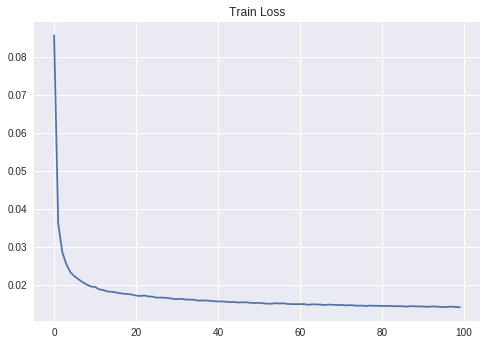

In [0]:
import matplotlib.pyplot as plt
train_losses = np.load('./CW/CAE/train_losses.npy')
plt.plot(list(range(0,train_losses.shape[0])), train_losses)
plt.title('Train Loss')
plt.show()

### Test set reconstruction error

In [0]:
# load the model
model.load_state_dict(torch.load('./CW/CAE/CAE_model.pth'))
model.eval()
test_loss = 0
with torch.no_grad():
    for i, data in enumerate(loader_test):
        img,_ = data
        img = img.to(device)
        recon_batch = model(img)
        test_loss += loss_function_CAE(recon_batch, img)
    # loss calculated over the whole test set
    test_loss /= len(loader_test.dataset)
    print('Test set loss: {:.4f}'.format(test_loss))

Test set loss: 0.0001


### Test set images and reconstructions

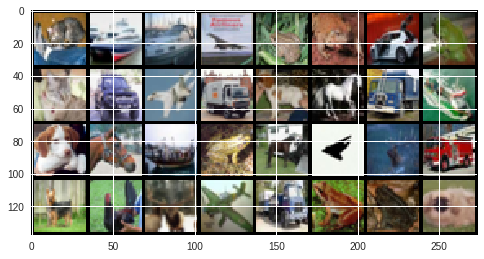

In [0]:
# load the model
model.load_state_dict(torch.load('./CW/CAE/CAE_model.pth'))
it = iter(loader_test)
sample_inputs, _ = next(it)
fixed_input = sample_inputs[0:32, :, :, :]

# visualize the original images of the last batch of the test set
img = make_grid(denorm(fixed_input), nrow=8, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
show(img)

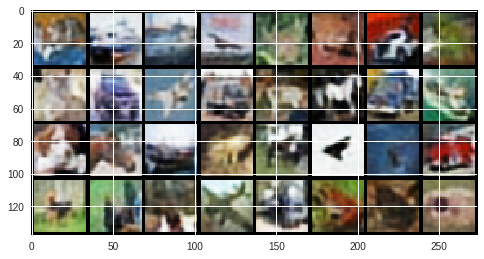

In [0]:
with torch.no_grad():
    # visualize the reconstructed images of the last batch of test set
    recon_batch = model(fixed_input.to(device)).cpu()
    recon_batch = make_grid(denorm(recon_batch), nrow=8, padding=2, normalize=False,
                            range=None, scale_each=False, pad_value=0)
    show(recon_batch)

### Part 1. 2 (20 points)
**Your Task**: 

In this part of the exercise you will use your pretrained encoder as a feature extractor in order to solve a downstream task:
* For every sample of your training set you will need to extract its latent representation by passing it through the encoder.
* Create a classifier of your choice and train it with the extracted features in order to predict the class that each image belongs to. You can access the sample's classes as follows:

`it = iter(loader_test)
samples, classes = next(it)`
* Use the encoder to encode all your test images into latent representations and then use your trained classifier to predict their classes
* Print the accuracy of your model.

The classifier can be trained with representations that do not yield very accurate reconstructions, so you can stop your training even if the reconstructed images are blurry. Also, note that you do not have to acheive high classification accuracy to get full marks for this question. Instead, focus on describing how you experimented in order to build your best classifier.

In [0]:
# *CODE FOR PART 1.2 IN THIS CELL*
# TODO change the conv layers' parameters
#######################################################################
#                       ** START OF YOUR CODE **
#######################################################################

################### Define the Convolutional Network ##################
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(64, 32, 3, stride=1, padding=1) # b, 32, 2, 2
        self.conv2 = nn.Conv2d(32, 16, 3, stride=1, padding=1) # b, 16, 2, 2
        self.fc = nn.Linear(16 * 2 * 2, 10)
#        self.fc2 = nn.Linear(32, 10)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 16 * 2 * 2)
        x = self.fc(x)
        #x = self.fc2(x)
        return x

          
########################### Initialization ###########################     
net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer_clf = torch.optim.Adam(net.parameters(), lr=0.001)
num_epoch = 200


########################### Train Model ###############################

def adjust_learning_rate(optimizer, decay_rate=.3): 
  for param_group in optimizer.param_groups: 
    param_group['lr'] = param_group['lr'] * decay_rate

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
      
for epoch in range(num_epoch):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(loader_train, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer_clf.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)
        # forward + backward + optimize
        z = model.encode(inputs) # b * 64 * 2 * 2
        outputs = net(z)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_clf.step()
        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 2000 mini-batches
          lr = get_lr(optimizer_clf)
          print('[%d, %5d] loss: %.3f  lr: %f' %(epoch + 1, i + 1, running_loss, lr))
          running_loss = 0.0       
    if epoch % 50 == 49:
        adjust_learning_rate(optimizer_clf)
          
print('Finished Training')



[1,   100] loss: 227.343  lr: 0.001000
[1,   200] loss: 209.519  lr: 0.001000
[1,   300] loss: 201.184  lr: 0.001000
[2,   100] loss: 190.933  lr: 0.001000
[2,   200] loss: 188.755  lr: 0.001000
[2,   300] loss: 185.194  lr: 0.001000
[3,   100] loss: 181.914  lr: 0.001000
[3,   200] loss: 179.073  lr: 0.001000
[3,   300] loss: 176.599  lr: 0.001000
[4,   100] loss: 174.175  lr: 0.001000
[4,   200] loss: 175.779  lr: 0.001000
[4,   300] loss: 173.188  lr: 0.001000
[5,   100] loss: 171.957  lr: 0.001000
[5,   200] loss: 171.319  lr: 0.001000
[5,   300] loss: 170.705  lr: 0.001000
[6,   100] loss: 168.221  lr: 0.001000
[6,   200] loss: 168.694  lr: 0.001000
[6,   300] loss: 170.262  lr: 0.001000
[7,   100] loss: 167.205  lr: 0.001000
[7,   200] loss: 167.088  lr: 0.001000
[7,   300] loss: 166.839  lr: 0.001000
[8,   100] loss: 166.211  lr: 0.001000
[8,   200] loss: 164.571  lr: 0.001000
[8,   300] loss: 164.704  lr: 0.001000
[9,   100] loss: 161.986  lr: 0.001000
[9,   200] loss: 163.184 

In [0]:
############################# test ####################################
correct = 0
total = 0
with torch.no_grad():
    for data in loader_test:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        z = model.encode(images) # b * 64 * 2 * 2        
        outputs = net(z)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
# name your accuracy variable as accuracy
print('Classification accuracy: {:.4f}'.format(accuracy))

#######################################################################
#                       ** END OF YOUR CODE **
####################################################################### 

Classification accuracy: 0.5158


## Part 2 - Deep Convolutional GAN

In this task, your main objective is to train a DCGAN (https://arxiv.org/abs/1511.06434) on the CIFAR-10 dataset. You should experiment with different architectures, tricks for stability in training (such as using different activation functions, batch normalization, different values for the hyper-parameters, etc.). In the end, you should provide us with: 

- your best trained model (which we will be able to run), 
- some generations for the fixed latent vectors $\mathbf{z}\sim \mathcal{N}\left(\mathbf{0}, \mathbf{I}\right)$ we have provided you with (train for a number of epochs and make sure there is no mode collapse), 
- plos with the losses for the discriminator $D$ and the generator $G$ as the training progresses and explain whether your produced plots are theoretically sensible and why this is (or not) the case. 
- a discussion on whether you noticed any mode collapse, where this behaviour may be attributed to, and explain what you did in order to cope with mode collapse. 

_Clarification: You should not be worrying too much about getting an "optimal" performance on your trained GAN. We want you to demonstrate to us that you experimented with different types of DCGAN variations, report what difficulties transpired throughout the training process, etc. In other words, if we see that you provided us with a running implementation, that you detail different experimentations that you did before providing us with your best one, and that you have grapsed the concepts, you can still get full marks. The attached model does not have to be perfect._

### Part 2.1 (30 points)
**Your Task**: 

a. Implement the DCGAN architecture. Fill in the missing parts in the cells below in order to complete the Generator and Discriminator classes. You will need to define:

- The hyperparameters
- The constructors
- `decode`
- `discriminator`

b. visualize images sampled from your best model's generator.

c. Discuss the experimentations which led to your final architecture. You can plot losses or generated results by other architectures that you tested to back your arguments (but this is not necessary to get full marks).

For b. the code is already given. Make sure that the version of the notebook you deliver includes these results. 

Recomendations for experimentation:
- use the architecture that you implemented for the Autoencoder of Part 1 (encoder as discriminator, decoder as generator).
- use the architecture desribed in the DCGAN paper (https://arxiv.org/abs/1511.06434).

Some general reccomendations:
- add several convolutional layers (3-4).
- accelerate training with batch normalization after every convolutional layer.
- use the appropriate activation functions. 
- Generator module: the upsampling can be done with various methods, such as nearest neighbor upsampling (`torch.nn.Upsample`) or transposed convolutions(`torch.nn.ConvTranspose2d`). 
- Discriminator module: Experiment with batch normalization (`torch.nn.BatchNorm2d`) and leaky relu (`torch.nn.LeakyReLu`) units after each convolutional layer.

Try to follow the common practices for CNNs (e.g small receptive fields, max pooling, RELU activations), in order to narrow down your possible choices.

The number of epochs that will be needed in order to train the network will vary depending on your choices. As an advice, we recommend that while experimenting you should allow around 20 epochs and if the loss doesn't sufficiently drop, restart the training with a more powerful architecture. You don't need to train the network to an extreme if you don't have the time.

### Hyper-parameter selection

In [0]:
# *CODE FOR PART 2.1 IN THIS CELL*

### Choose the number of epoch, the learning rate
#   and the size of the Generator's input noise vetor.
num_epochs = 20
learning_rate  = 2e-4
latent_vector_size = 100
###

# Define here other hyperparameters that you used.
OPTIM_BETAS = (0.5, 0.999)
# Size of feature maps in generator
ngf = 64
# Size of feature maps in discriminator
ndf = 64
# Number of channels in the training images. For color images this is 3
nc = 3

In [0]:
# *CODE FOR PART 2.1 IN THIS CELL* 
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        self.G = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(latent_vector_size, ngf * 8, 2, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()

        )

        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

    def decode(self, z):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        x = self.G(z)
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        return x

    def forward(self, z):
        return self.decode(z)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        self.encoder = nn.Sequential(
            # input is (nc) x 32 x 32
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
 #           nn.Conv2d(ndf * 4, 1, 4, 2, 1, bias=False),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, 1, 2, 1, 0, bias=False),
            nn.Sigmoid()
        )
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        
    def discriminator(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        out = self.encoder(x)
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        
        return out

    def forward(self, x):
        outs = self.discriminator(x)
        return outs.view(-1, 1).squeeze(1)

### Initialize Model and print number of parameters

You can use method `weights_init` to initialize the weights of the Generator and Discriminator networks. Otherwise, implement your own initialization, or do not use at all. You will not be penalized for not using initialization.

In [0]:


# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [0]:
use_weights_init = True

model_G = Generator().to(device)
if use_weights_init:
    model_G.apply(weights_init)
params_G = sum(p.numel() for p in model_G.parameters() if p.requires_grad)
print("Total number of parameters in Generator is: {}".format(params_G))
print(model_G)
print('\n')

model_D = Discriminator().to(device)
if use_weights_init:
    model_D.apply(weights_init)
params_D = sum(p.numel() for p in model_D.parameters() if p.requires_grad)
print("Total number of parameters in Discriminator is: {}".format(params_D))
print(model_D)
print('\n')

print("Total number of parameters is: {}".format(params_G + params_D))

Total number of parameters in Generator is: 2962304
Generator(
  (G): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(2, 2), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=F

### Define loss function

In [0]:
criterion = nn.BCELoss(reduction='mean')
def loss_function(out, label):
    loss = criterion(out, label)
    return loss

### Choose and initialize optimizers

In [0]:
# setup optimizer
# You are free to add a scheduler or change the optimizer if you want. We chose one for you for simplicity.
# beta1 = 0.5
optimizerD = torch.optim.Adam(model_D.parameters(), lr=learning_rate, betas=OPTIM_BETAS)
optimizerG = torch.optim.Adam(model_G.parameters(), lr=learning_rate, betas=OPTIM_BETAS)

### Define fixed input vectors to monitor training and mode collapse.

In [0]:
fixed_noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
real_label = 1
fake_label = 0

### Train

In [0]:
export_folder = './CW/DCGAN'
train_losses_G = []
train_losses_D = []

for epoch in range(num_epochs):
    for i, data in enumerate(loader_train, 0):
        train_loss_D = 0
        train_loss_G = 0
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        model_D.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device)

        output = model_D(real_cpu)
        errD_real = loss_function(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
        fake = model_G(noise)
        label.fill_(fake_label)
        output = model_D(fake.detach())
        errD_fake = loss_function(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        train_loss_D += errD.item()
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        model_G.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = model_D(fake)
        errG = loss_function(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        train_loss_G += errG.item()
        optimizerG.step()
        if i % 300 == 299:
          print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                % (epoch, num_epochs, i, len(loader_train),
                   errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

    if epoch == 0:
        save_image(denorm(real_cpu.cpu()), './CW/DCGAN/real_samples.png')
    
    fake = model_G(fixed_noise)
    save_image(denorm(fake.cpu()), './CW/DCGAN/fake_samples_epoch_%03d.png' % epoch)
    train_losses_D.append(train_loss_D / len(loader_train))
    train_losses_G.append(train_loss_G / len(loader_train))
            
# save losses and models
np.save('./CW/DCGAN/train_losses_D.npy',np.array(train_losses_D))
np.save('./CW/DCGAN/train_losses_G.npy',np.array(train_losses_G))
torch.save(model_G.state_dict(), './CW/DCGAN/DCGAN_model_G.pth')
torch.save(model_D.state_dict(), './CW/DCGAN/DCGAN_model_D.pth')


[0/20][299/383] Loss_D: 0.3689 Loss_G: 6.6033 D(x): 0.7596 D(G(z)): 0.0160 / 0.0019
[1/20][299/383] Loss_D: 0.2869 Loss_G: 4.4461 D(x): 0.8418 D(G(z)): 0.0798 / 0.0162
[2/20][299/383] Loss_D: 0.5484 Loss_G: 4.6286 D(x): 0.6814 D(G(z)): 0.0175 / 0.0184
[3/20][299/383] Loss_D: 0.3540 Loss_G: 4.5042 D(x): 0.8556 D(G(z)): 0.1407 / 0.0164
[4/20][299/383] Loss_D: 0.7207 Loss_G: 6.6374 D(x): 0.8712 D(G(z)): 0.3513 / 0.0039
[5/20][299/383] Loss_D: 0.2165 Loss_G: 6.0652 D(x): 0.8417 D(G(z)): 0.0155 / 0.0072
[6/20][299/383] Loss_D: 0.5394 Loss_G: 3.5160 D(x): 0.7574 D(G(z)): 0.1634 / 0.0462
[7/20][299/383] Loss_D: 0.5011 Loss_G: 4.3571 D(x): 0.8241 D(G(z)): 0.2106 / 0.0219
[8/20][299/383] Loss_D: 0.5032 Loss_G: 4.3384 D(x): 0.8133 D(G(z)): 0.1993 / 0.0223
[9/20][299/383] Loss_D: 0.3346 Loss_G: 4.6379 D(x): 0.8793 D(G(z)): 0.1502 / 0.0195
[10/20][299/383] Loss_D: 0.4281 Loss_G: 4.9164 D(x): 0.9191 D(G(z)): 0.2499 / 0.0116
[11/20][299/383] Loss_D: 0.5876 Loss_G: 3.6093 D(x): 0.8446 D(G(z)): 0.2918

In [0]:
# DISCUSS THE SELECTION OF THE ARCHITECTURE IN THIS CELL*


### Generator samples

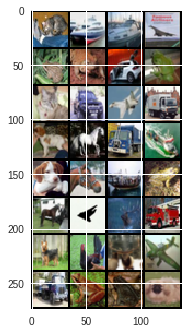

In [0]:
it = iter(loader_test)
sample_inputs, _ = next(it)
fixed_input = sample_inputs[0:32, :, :, :]

# visualize the original images of the last batch of the test set
img = make_grid(denorm(fixed_input), nrow=4, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
show(img)

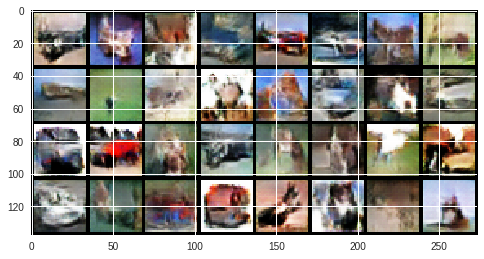

In [0]:
# load the model
model_G.load_state_dict(torch.load('./CW/DCGAN/DCGAN_model_G.pth'))
input_noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)

with torch.no_grad():
    # visualize the generated images
    generated = model_G(input_noise).cpu()
    generated = make_grid(denorm(generated)[:32], nrow=8, padding=2, normalize=False, 
                        range=None, scale_each=False, pad_value=0)
    show(generated)

### Part 2.2 (10 points)

### Train losses curves
**Your task:**


Plot the losses curves for the discriminator $D$ and the generator $G$ as the training progresses and explain whether the produced curves are theoretically sensible and why this is (or not) the case (x-axis: epochs, y-axis: loss).

The code for generating the plot is already given. Make sure that the version of the notebook you deliver includes these results.

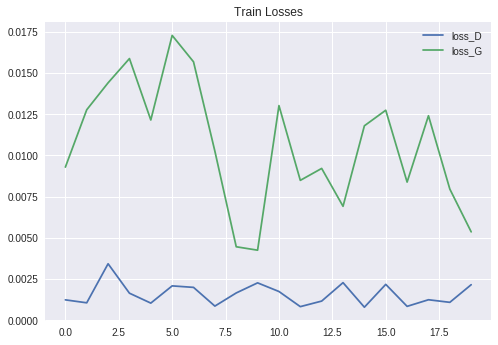

In [0]:
import matplotlib.pyplot as plt
train_losses_D = np.load('./CW/DCGAN/train_losses_D.npy')
train_losses_G = np.load('./CW/DCGAN/train_losses_G.npy')
plt.plot(list(range(0,train_losses_D.shape[0])), train_losses_D, label='loss_D')
plt.plot(list(range(0,train_losses_G.shape[0])), train_losses_G, label='loss_G')
plt.legend()
plt.title('Train Losses')
plt.show()

### ANSWER FOR PART 2.2 IN THIS CELL
The loss value of generator should be smaller than the loss value of discriminator at the end, which means the generator can fool the discriminator. In my loss graph, though the loos of G is still higher than the loss of D, but the loss of G tends to decrease while the loss of D tends to increase, which indicates that the generator starts to fool the dicriminator. 

### Part 2.3 (10 points) 
**Your task:** 

Based on the images created by your generator using the `fixed_noise` vector during training, provide a discussion on whether you noticed any mode collapse, where this behaviour may be attributed to, and explain what you did in order to cope with mode collapse.

### ANSWER FOR PART 2.3 IN THIS CELL
Because I got almost all the classes, so I think my last architecture has no mode collapse.

By comparing some architectures in generator and discriminator, I find some useful tricks which may be helpful in preventing the mode collapse:

*   Using Batch Normalization after each convolution layer in both generator and discriminator to help gradient flow;
*   Instead of full conneted layer in the last layer by doing the convolution layer;
*   Instead of using ReLU activation function in discriminator by using leakyReLU and using sigmoid function in the last layer;
*   Using ReLU activation function in generator except the last layer which uses tanh function;
*   Make sure to increase the channels in the previous layers and decrease it to a specific channel number in both models.

